In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('Stability_Data_March2018.csv', index_col=0)
df.head()

,runstring,t_final_short,Rel_Eerr_short,avg_beta12,std_beta12,min_beta12,max_beta12,avg_beta23,std_beta23,min_beta23,...,min_iH3,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a3_slope,wall_time,Stable,instability_time,Rel_Eerr
0,0000000.bin,10000.0,1.346025e-08,8.488064,0.048209,8.344623,8.551727,15.791595,0.085995,15.576612,...,4.410404,0.297364,0.016641,0.339655,0.010871,2.681898e-11,0.395531,0.0,1.235644e+07,1.099985e-04
1,0000001.bin,10000.0,8.934681e-10,8.414875,0.039142,8.308582,8.495900,15.314101,0.037065,15.254833,...,0.588028,0.115674,0.039718,0.251880,0.137917,-9.314702e-11,0.403877,0.0,1.348749e+05,1.388587e-08
2,0000002.bin,10000.0,3.169983e-08,3.566625,0.132349,3.331239,3.773868,25.113282,0.137779,24.898424,...,0.875622,0.038930,0.002380,0.026117,0.007227,-4.095504e-11,0.397334,0.0,1.276381e+04,3.048261e-04
3,0000003.bin,10000.0,6.097589e-10,18.513867,0.003597,18.498104,18.521611,19.142029,0.008997,19.120348,...,9.650551,0.514386,0.003658,0.301072,0.279903,-7.257099e-12,0.391764,1.0,1.000000e+09,6.492574e-10
4,0000004.bin,10000.0,5.951220e-03,23.314674,6.756316,3.957209,38.942908,-19.036068,5.544896,-21.930247,...,0.154157,0.496372,0.248052,1.358604,0.261358,-2.610208e-08,0.402905,0.0,8.791888e+01,9.336734e-07


# Feature Legend
The next cell below lists the features calculated for this dataset. An explanation of those features is given here:

### Physical values
- ```a1``` = $a_1$ = semi-major axis of inner-most planet.  
- ```e1``` = $e_1$ = eccentricity of inner-most planet.  
- ```inc1``` = $inc_1$ = inclination of inner-most planet.  
- ```beta12``` = $\frac{a_2 - a_1}{R_{H,1}}$ = separation of inner and middle planet in units of Hill radius $R_H$.  
Where:  
$R_{H,1} = a_1\left(\frac{m_1 + m_2}{3M_s}\right)^{1/3}$  
$m_i$ = mass of planet $i$  
$M_s$ = stellar mass = 1  
- ```ecross1``` = $e_1/\gamma_1$ = eccentricity of first planet divided by the relative distance between planets.  
Where:  
$\gamma_1 = \frac{a_2 - a_1}{a_1}$  
- ```eH1``` = $e_1/R_{HE,1}$ = eccentricity of first planet divided by the relative planet/star masses of the bodies.  
Where:  
$R_{HE,1} = R_{H,1}/a_1$

### Statistics
Features are generated from the first 10,000 orbits of the system. 100 time-stamps are taken over this time (once every 100 years), and various statistics of the above physical values are taken:
- ```avg``` = average of all points.  
- ```std``` = standard deviation of all points.  
- ```min``` = minimum of all points.  
- ```max``` = maximum of all points.  
- ```norm``` = divide by the mean value.  
- ```window10``` = 


In [7]:
list(df.columns)

['runstring',
 't_final_short',
 'Rel_Eerr_short',
 'avg_beta12',
 'std_beta12',
 'min_beta12',
 'max_beta12',
 'avg_beta23',
 'std_beta23',
 'min_beta23',
 'max_beta23',
 'avg_a1',
 'std_a1',
 'max_a1',
 'min_a1',
 'norm_std_a1',
 'norm_max_a1',
 'norm_std_window10_a1',
 'norm_max_window10_a1',
 'avg_e1',
 'std_e1',
 'max_e1',
 'min_e1',
 'norm_std_e1',
 'norm_max_e1',
 'norm_std_window10_e1',
 'norm_max_window10_e1',
 'avg_inc1',
 'std_inc1',
 'max_inc1',
 'min_inc1',
 'norm_std_inc1',
 'norm_max_inc1',
 'norm_std_window10_inc1',
 'norm_max_window10_inc1',
 'avg_eH1',
 'std_eH1',
 'max_eH1',
 'min_eH1',
 'avg_iH1',
 'std_iH1',
 'max_iH1',
 'min_iH1',
 'avg_ecross1',
 'std_ecross1',
 'max_ecross1',
 'min_ecross1',
 'norm_a1_slope',
 'avg_a2',
 'std_a2',
 'max_a2',
 'min_a2',
 'norm_std_a2',
 'norm_max_a2',
 'norm_std_window10_a2',
 'norm_max_window10_a2',
 'avg_e2',
 'std_e2',
 'max_e2',
 'min_e2',
 'norm_std_e2',
 'norm_max_e2',
 'norm_std_window10_e2',
 'norm_max_window10_e2',
 'avg

## Basic plotting
Let's plot the data to get a sense of what it looks like.

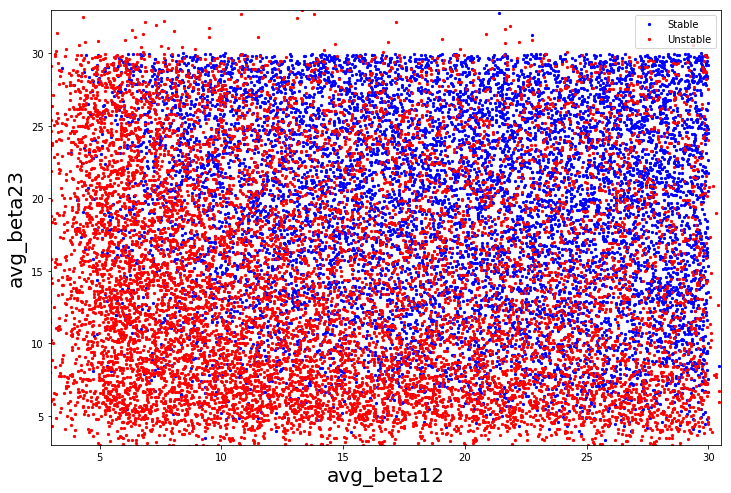

In [32]:
x = 'avg_beta12'
y = 'avg_beta23'


fig, ax = plt.subplots(figsize=(12,8))
stable = df['Stable'] == 1
unstable = df['Stable'] == 0
ax.scatter(df.loc[stable, x], df.loc[stable, y], color='blue', s=5, label='Stable')
ax.scatter(df.loc[unstable, x], df.loc[unstable, y], color='red', s=5, label='Unstable')
ax.set_xlim([3,30.5])
ax.set_ylim([3,33])
ax.set_xlabel(x, fontsize=20)
ax.set_ylabel(y, fontsize=20)
ax.legend()

## Generate Training and Testing Datasets

In [34]:
features = []
features += ['avg_iH1', 'avg_iH2']
features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
features += ['avg_beta12','std_beta12','min_beta12','max_beta12','avg_beta23','std_beta23','min_beta23','max_beta23'] 
y = df['Stable']
X = df[features]
X.head()

,avg_iH1,avg_iH2,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,norm_std_a2,norm_max_a2,norm_std_window10_a2,norm_max_window10_a2,...,norm_a2_slope,norm_a3_slope,avg_beta12,std_beta12,min_beta12,max_beta12,avg_beta23,std_beta23,min_beta23,max_beta23
0,0.396282,0.481704,0.000329,0.001083,0.000214,0.000456,0.000701,0.001978,0.000446,0.000964,...,2.144832e-10,2.681898e-11,8.488064,0.048209,8.344623,8.551727,15.791595,0.085995,15.576612,16.019985
1,1.034575,0.823935,0.000739,0.002137,0.000202,0.000463,0.000200,0.000350,0.000226,0.000377,...,3.559377e-11,-9.314702e-11,8.414875,0.039142,8.308582,8.495900,15.314101,0.037065,15.254833,15.368196
2,0.440470,0.491261,0.001951,0.003550,0.001735,0.002860,0.002303,0.004034,0.002080,0.003409,...,-3.330088e-11,-4.095504e-11,3.566625,0.132349,3.331239,3.773868,25.113282,0.137779,24.898424,25.351948
3,0.432098,0.550624,0.000026,0.000120,0.000005,0.000009,0.000019,0.000050,0.000016,0.000041,...,7.816527e-13,-7.257099e-12,18.513867,0.003597,18.498104,18.521611,19.142029,0.008997,19.120348,19.156777
4,5.722053,17.442426,0.028284,0.063028,0.004313,0.010716,0.038832,0.160685,0.090892,0.112168,...,3.913858e-08,-2.610208e-08,23.314674,6.756316,3.957209,38.942908,-19.036068,5.544896,-21.930247,4.156005
